In [14]:
import numpy as np
from scipy import signal
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.signal import peak_prominences
import natsort
import pandas as pd
from scipy.signal import butter, lfilter, freqz, filtfilt
from scipy.special import erfc

import glob
import matplotlib.pyplot as plt
plt.style.use('../../style.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [15]:
def rebin(hx,h,bins):
    h_rebin=[]
    # hx_rebin=[]
    for i in range(int(len(h)/bins)):
        start_idx=i*bins
        end_idx=(i+1)*bins
        h_rebin.append(np.sum(h[start_idx:end_idx]))
        # hx_rebin.append(np.mean(hx[start_idx:end_idx]))
    hx_rebin=range(len(h_rebin))
    return np.array(hx_rebin), np.array(h_rebin)

In [16]:
def gauss(x,a,mu,sigma):
    return (a*np.exp(-0.5*((x-mu)/sigma)**2))

In [17]:
def line_gain(x,m,c):
    return (m*x)+c

In [18]:
#Path to the folder containing the files with E=0V/cm

Path=r"C:\Users\nEXO\Downloads\Gain_LED_Settings_SRS_0" #LXe
# Path=r"C:\Users\nEXO\Downloads\Gain_-110C_0" #Vacuum

In [19]:
#Path to the folder containing the files with E=260 V/cm

# Path=r"C:\Users\nEXO\Downloads\Gain_LED_Settings_SRS_273" #LXe
# Path=r"C:\Users\nEXO\Downloads\Gain_-110C_260" #Vacuum

In [20]:
#Path to folder containing files with E=260 V/cm and NO SRS
# Path=r"C:\Users\nEXO\Downloads\Gain_No_SRS_273\IN2-POS_29.5V.csv" #Lxe

In [21]:
def gain_calculator(PATH):
    BINS=5 #Number of bins to rebin the MCA data with
    N_peaks= 3# Number o peaks to use for calculating the gain
    gain_list=[] #empty list to fill in the values of gain, returned at the end of this function
    gain_err=[] #empty list to fill in the values of gain fit error, returned at the end of this function


    Files = glob.glob(PATH+"\*.csv")

    #for loop to loop over all the files
    for i,file in enumerate(natsort.realsorted(Files)): 

        #use pandas dataframe 
        df=pd.read_csv(file,skiprows=1)

        #rebin the files with the bin width specified by BINS
        hx,h = rebin(np.array(df['Channel']), np.array(df['Counts']), BINS)

        gain_temp=[]#reset the gain temp list here to store gain values for one file

        #Use scipy find_peaks to find peaks starting with a very high prominence 

        PROMINENCE=1000 #This prominence is re-set here to ensure that every file starts out with a high prominence

        peaks,pdict=find_peaks(h,prominence=PROMINENCE)

        peak_length=len(peaks)

        #We want to ensure that using a high prominence gives us at least 3 peaks to fit a straight line to. If it doesn't we reduce prominence till we get at least 3 peaks. N_peaks is set above
        while (peak_length<N_peaks+1):
            PROMINENCE=PROMINENCE-1
            peaks,pdict=find_peaks(h,prominence=PROMINENCE)
            peak_length=len(peaks)
        
        #To avoid fitting the pedestal, we ignore the first peak. In case the pedestal isn't there, then first peak gets ignored. This shouldn't change gain or BV calculation

        first_pe_max=hx[peaks[1]] # The x-value of the 2nd peak.Index=1 means the second peak will be used for getting fit parameters
        max_value=h[peaks[1]] # The height of the 2nd peak

        x_idx_array=(h<0.5*max_value) & (hx>first_pe_max)# returns a boolean array where both conditions are true

        right_side_x= hx[np.where(x_idx_array)[0][0]] #finding the first time where x_idx_array is True
        
        sigma_guess=np.abs(first_pe_max-right_side_x) #We need this to fit the width of the Gaussian peaks

        plt.figure(figsize=(12,5)) # Call the figure here

        plt.subplot(1,2,1) #This subplot will plot the position of the peaks and also the data


        plt.plot(hx[peaks],h[peaks],'*') # plot the peak markers

        plt.step(hx,h,lw=1) #plot the signal

        cut= (hx < first_pe_max+sigma_guess) & (hx > first_pe_max-sigma_guess) # This cut helps to fix the width of the peak-fit

        popt,pcov=curve_fit(gauss,hx[cut],h[cut],p0=[max_value,first_pe_max,sigma_guess]) # We use curve_fit to return the optimal parameters and the covariance matrix

        plt.plot(hx[cut],gauss(hx[cut],*popt),color='green',label='Fit',lw=2,alpha=0.5) # Here we plot the fit on the 2nd peak to see if everything looks ok.

        plt.xlim(0,80*(i+1)) #changing the limits of the x-axis based on the different  OVs

        plt.yscale('log')

        for i,peak in enumerate(peaks[1:]): #here we ignore the first peak because it could be the pedestal
        


            new_first_pe_max=hx[peak] #x-value of the peak


            new_max_value=h[peak] #height of the peak


        

            new_x_idx_array=(h<0.5*new_max_value) & (hx>new_first_pe_max) # returns a boolean array where both conditions are true


            new_right_side_x= hx[np.where(new_x_idx_array)[0][0]] #finding the first time where x_idx_array is True



            new_sigma_guess=np.abs(new_first_pe_max-new_right_side_x) #We need this to fit the width of the Gaussian peaks


            new_cut= (hx < new_first_pe_max+new_sigma_guess) & (hx > new_first_pe_max-new_sigma_guess) # This cut helps to fix the width of the peak-fit

            popt_new,pcov_new=curve_fit(gauss,hx[new_cut],h[new_cut],p0=[new_max_value,new_first_pe_max,new_sigma_guess],maxfev=100000) # We use curve_fit to return the optimal parameters and the covariance matrix

            plt.plot(hx[new_cut],gauss(hx[new_cut],*popt_new),color='r',label='Fit',lw=3) # Here we plot the fit on all the peaks

            gain_temp.append(popt_new[1]) #Here we append the value of the peak fit mean 
    
        plt.subplot(1,2,2) #This subplot shows the straight line fit to the peak means to obtain the slope/gain


        popt_temp,pcov_temp=curve_fit(line_gain,np.arange(1,len(peaks)),gain_temp,p0=[90,5],maxfev=10000) #Use the straight line fit here

        plt.plot(np.arange(1,len(peaks)),line_gain(np.arange(1,len(peaks)),*popt_temp),color='k',label=(str(np.round(popt_temp[0],2)))+'$\pm$'+str(np.round(np.sqrt(np.diag(pcov_temp))[0],2))+' ADC/PE') # plot the straight line fit

        plt.scatter(np.arange(1,len(peaks)),gain_temp,color='r') #plot the values of the peak means

        plt.legend(loc=2)

        plt.show() #show the plot

        gain_list.append(popt_temp[0]) #append the gain values to obtain BV later
        gain_err.append(np.sqrt(np.diag(pcov_temp))[0]) #append the straight line error fit 
    return(np.array(gain_list),np.array(gain_err))

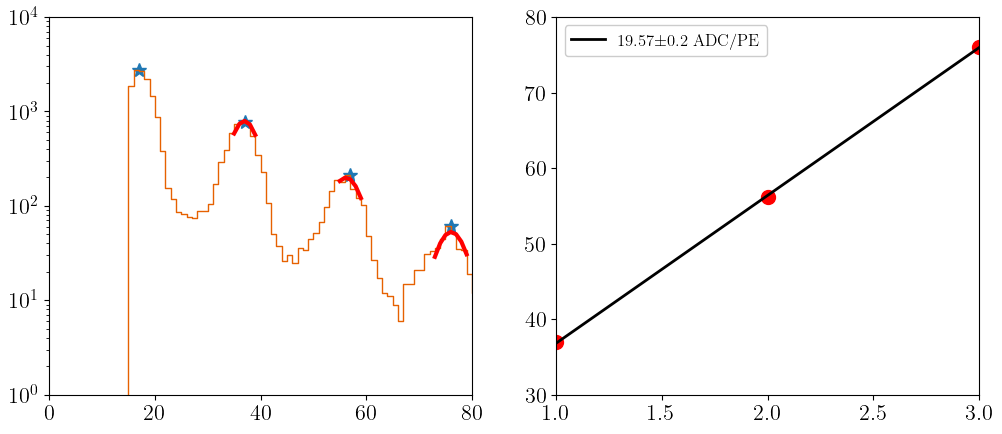

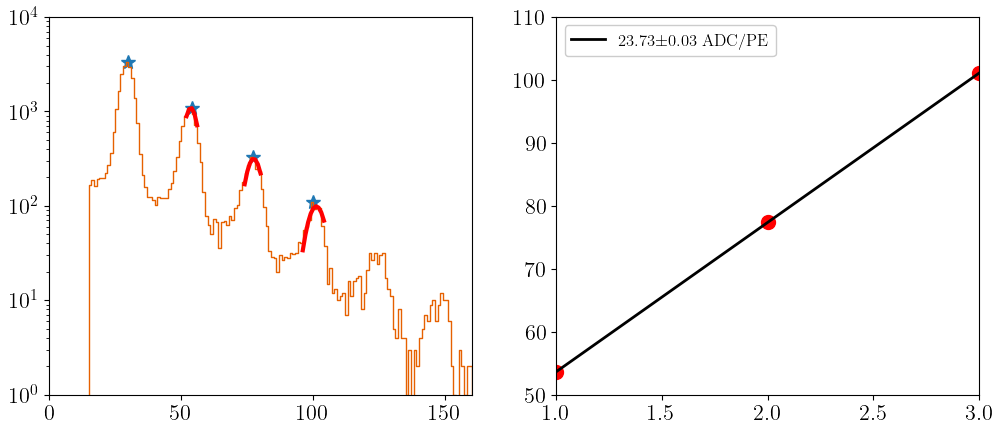

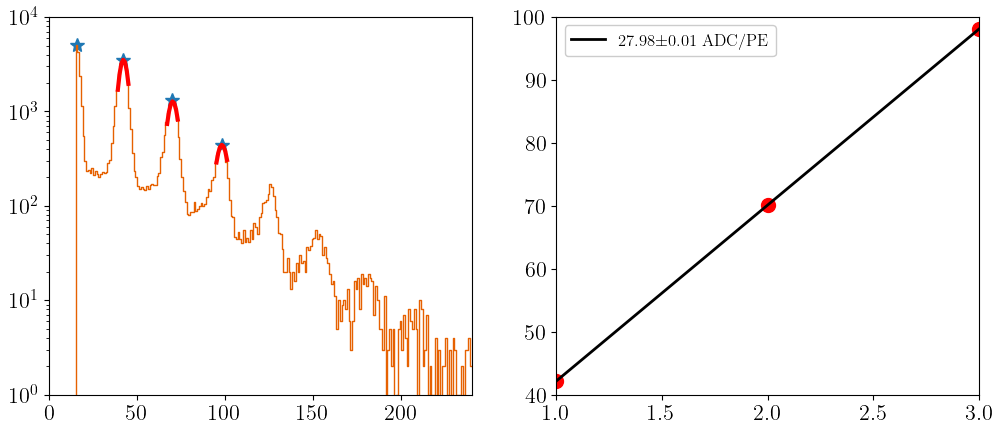

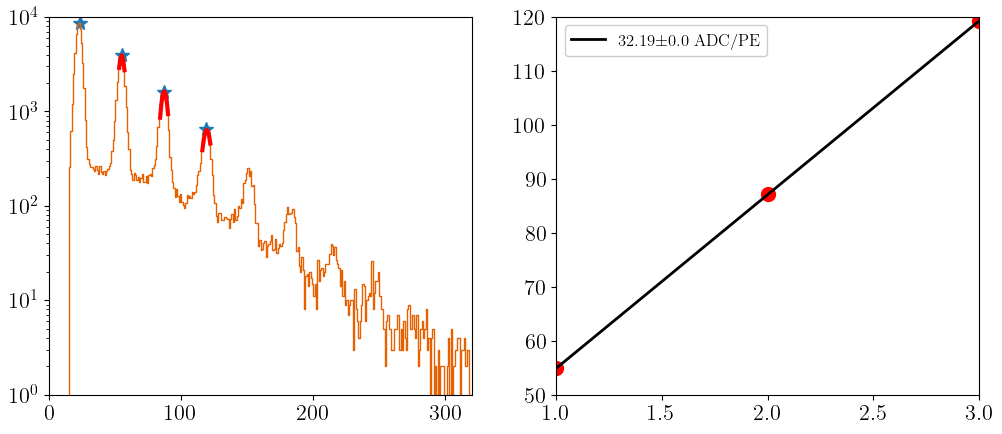

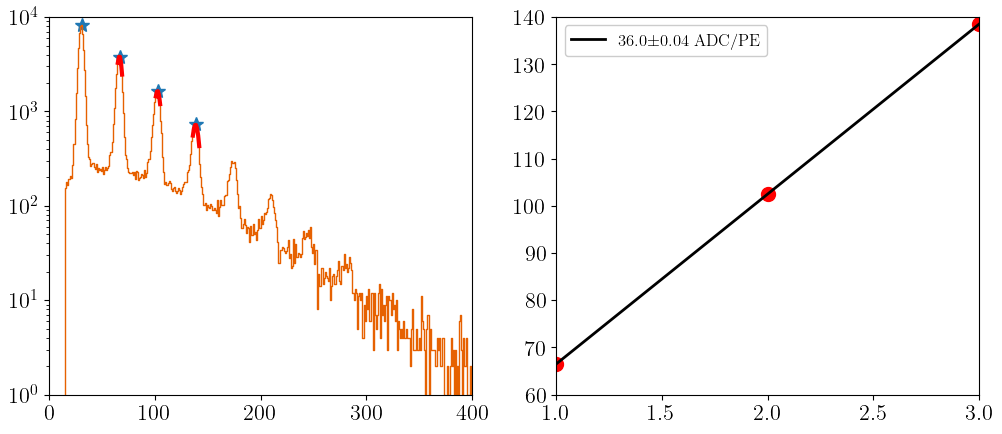

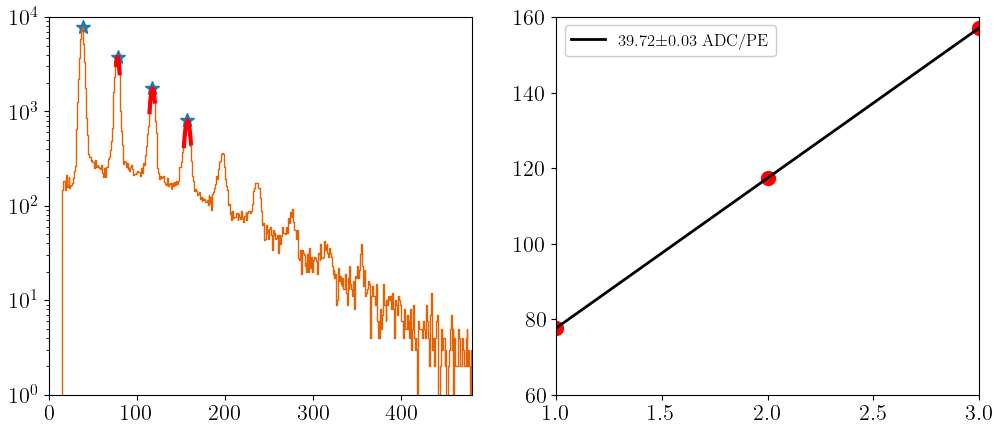

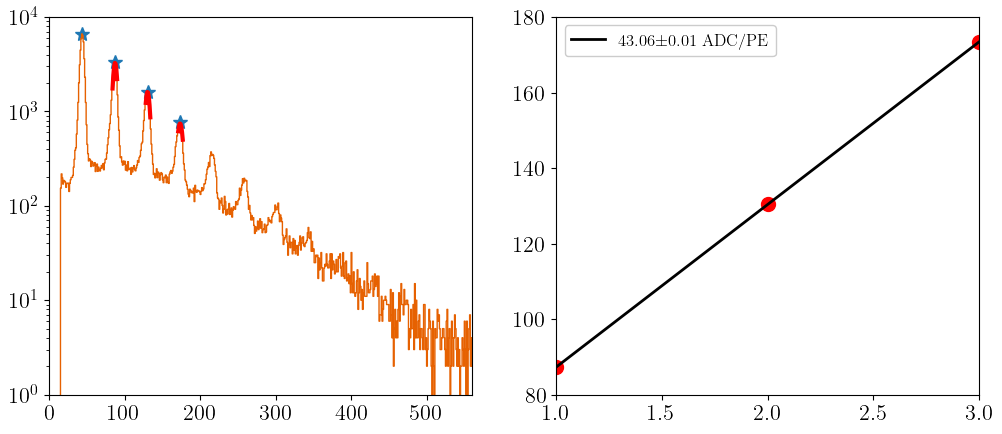

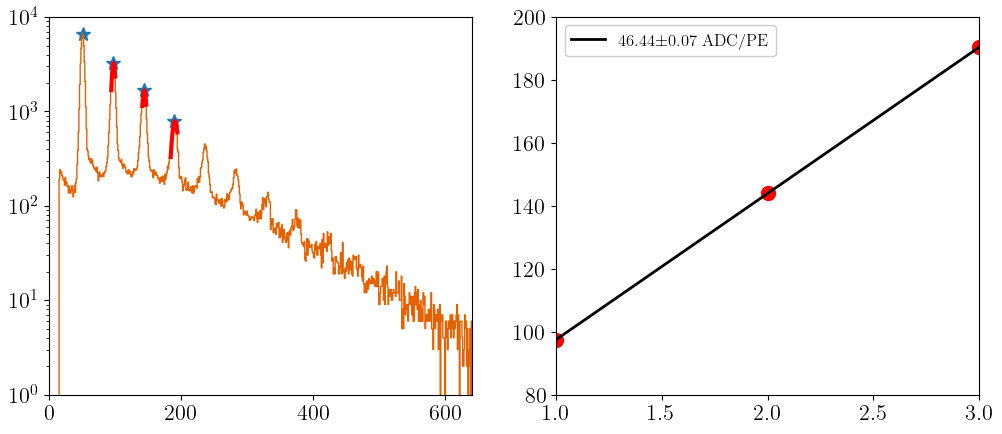

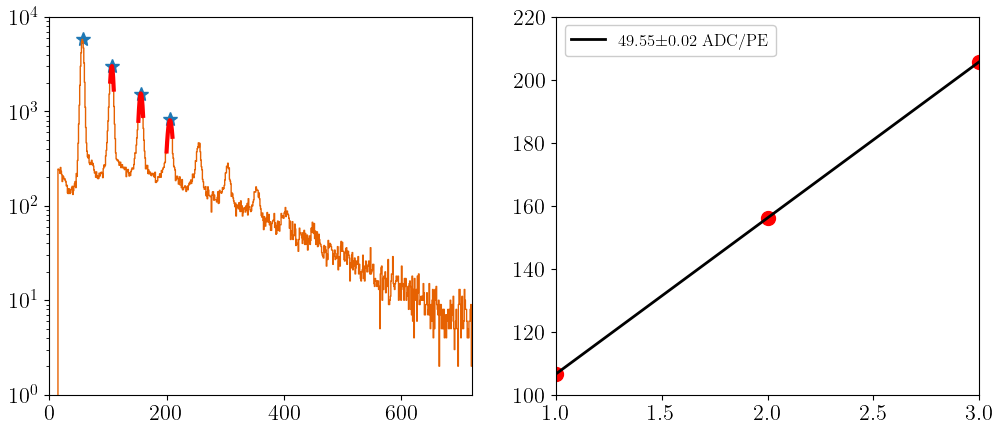

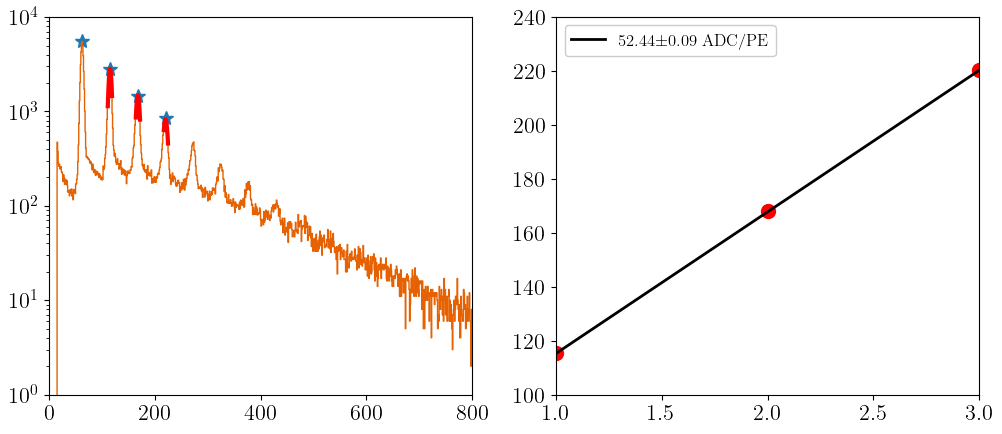

In [22]:
gain_list_0V,gain_err_0V=gain_calculator(Path)

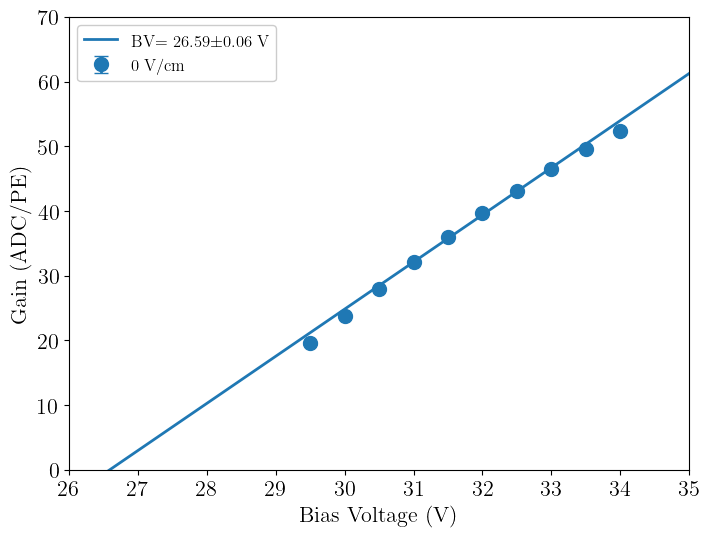

In [23]:
def line(x,a,b):
    return a*(x-b)
x_data=np.arange(0,100,1)
BV_list=np.arange(29.5,34.5,0.5)
plt.errorbar(BV_list,gain_list_0V,yerr=gain_err_0V,label='0 V/cm',fmt='o',ms=10)
# plt.errorbar(BV_list,gain_list_260V,yerr=gain_err_260V,label='260 V/cm',fmt='o',ms=10)

popt_0,pcov_0=curve_fit(line,BV_list,gain_list_0V,p0=[31,27],sigma=gain_err_0V)
# popt_260,pcov_260=curve_fit(line,BV_list,gain_list_260V,p0=[31,27],sigma=gain_err_260V)
plt.plot(x_data,line(x_data,*popt_0),color=colors[0],label='BV= '+str(np.round(popt_0[1],2))+ '$\pm$'+ str(np.round(np.sqrt(np.diag(pcov_0)[1]),2))+' V')
# plt.plot(x_data,line(x_data,*popt_260),color=colors[1],label='BV= '+str(np.round(popt_260[1],2))+ '$\pm$'+ str(np.round(np.sqrt(np.diag(pcov_260)[1]),2))+' V',ls='--')
plt.ylabel('Gain (ADC/PE)')
plt.xlabel('Bias Voltage (V)')
plt.xlim(26,35)
plt.ylim(0,70)
# plt.title('LXe')
plt.legend(loc=2)
plt.savefig('BV_comparison.pdf')
plt.show()

# gain_list_0V_LXe_SRS =gain_list_0V
# gain_list_260V_LXe_SRS =gain_list_260V

# gain_err_0V_LXe_SRS= gain_err_0V
# gain_err_260V_LXe_SRS= gain_err_260V

# %store gain_list_0V_LXe_SRS gain_list_260V_LXe_SRS gain_err_0V_LXe_SRS gain_err_260V_LXe_SRS